Controllability

d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


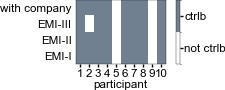

In [1]:
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from custom_rcparams_paper import colors

data = utils.load_data()    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
controllable = np.zeros((len(data), len(intervs)), dtype=bool)

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['C']
    for i in range(len(intervs)):
        controllable[j,i] = LQR.controllable(A, B[:,i:i+1])

fig, ax = plt.subplots(figsize=(1.8,0.9))
cmap = colors.binary_cmap
ax, cbar = utils.colorplot_trajectory(controllable, labels=intervs, ax=ax, cmap=cmap,
                                      norm=mpl.colors.BoundaryNorm([-0.5,0.5,1.5], 200),
                                      origin='lower')
ax.set_xticks(range(len(data)), labels=range(1, len(data)+1))#['',2,'',4,'',6,'',8,'',10])
ax.set_xlabel('participant')
cbar.ax.set_yticks([0,1], labels=['not ctrlb', 'ctrlb'])
plt.savefig('figures/figure2Al.png')


Average controllability of EMIs

[35.12922028 44.27630731 40.23554896 13.68209155]
TtestResult(statistic=2.056431495085617, pvalue=0.069882653816032, df=9)


d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


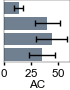

In [53]:
from scipy import stats
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors

data = utils.load_data()    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
gramtrace = np.zeros((len(data), len(intervs)))

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['C']
    for i in range(len(intervs)):
        gramtrace[j,i] = np.diag(LQR.ctrb_gramian(A, B[:,i:i+1], 15)).sum()

fig, ax = plt.subplots(figsize=(0.7,0.9))
ax.barh(range(len(intervs)), gramtrace.mean(axis=0), xerr=stats.sem(gramtrace, axis=0),
        color=colors.standard, ecolor=colors.errorbars)
# ax.set_yticks(range(len(intervs)), labels=intervs)
ax.set_yticks([])
ax.set_xticks([0,25,50])
ax.set_ylim([-0.5, len(intervs)-0.5])
ax.tick_params(which='major', left=False)
ax.set_xlabel('AC')
plt.savefig('figures/figure2Ar.png')

print(gramtrace.mean(axis=0))
print(stats.ttest_rel(gramtrace[:,:3].mean(axis=1), gramtrace[:,3]))

Average Controllability of Items

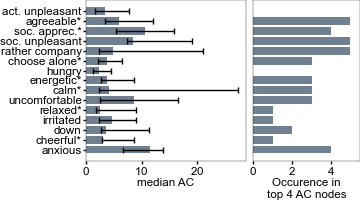

In [4]:
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors
from scipy import stats

data = utils.load_data()    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
ac = np.zeros((len(data), len(features)))
mc = np.zeros((len(data), len(features)))

statistic = 'median'

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['C']
    ac[j] = LQR.average_ctrb(A, 15)

top4ac = np.r_[np.argsort(ac, axis=1)[:,-1:-5:-1].flatten(), np.arange(len(features))].copy()
_, top4ac_counts = np.unique(top4ac, return_counts=True)
top4ac_counts -= 1

fig, axes = plt.subplots(1,2, figsize=(3.6,2), sharey=True, gridspec_kw={'width_ratios':(1.5,1)})
ax = axes[0]

if statistic=='median':
    interval = np.vstack((np.percentile(ac, 25, axis=0), np.percentile(ac, 75, axis=0)))
    bar_container = ax.barh(range(len(features)), np.median(ac, axis=0), color=colors.features,
            xerr=np.abs(np.median(ac, axis=0, keepdims=True)-interval), error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('median AC')
    ax.set_xticks([0,10,20])
elif statistic=='mean':
    interval = stats.sem(ac, axis=0)
    bar_container = ax.barh(range(len(features)), np.mean(ac, axis=0), color=colors.features,
            xerr=interval, error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('mean AC')
    ax.set_xticks([0,20,40])

ax.set_yticks(np.arange(len(features)), labels=features)
ax = axes[1]
ax.barh(range(len(features)), top4ac_counts)
ax.set_xlabel('Occurence in\ntop 4 AC nodes')
ax.set_xticks([0,2,4])
ax.set_xlim([0, 5.5])
ax.tick_params(left=False)
plt.savefig('figures/figure2C.png')

Edge weight vs. AC

Correlation: r=0.7224624981818834, p=1.7200241747627994e-25


d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


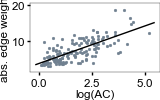

In [5]:
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from custom_rcparams_paper import colors

data = utils.load_data()    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
ac = np.zeros((len(data), len(features)))
sum_incoming_weights = np.zeros((len(data), len(features)))
sum_outgoing_weights = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    ac[j] = LQR.average_ctrb(A, 15)
    sum_incoming_weights[j] = np.sum(np.abs(A), axis=1)
    sum_outgoing_weights[j] = np.sum(np.abs(A), axis=0) 

with mpl.rc_context({'lines.markersize':2}):
    fig, ax = plt.subplots(figsize=(1.6,1))
    # ax.set_xscale('log')
    ax, corr = utils.plot_regression(np.log(ac).flatten(), (sum_incoming_weights + sum_outgoing_weights).flatten(), ax=ax,
                        scatter_kwargs={'color':colors.standard}, line_kwargs={'color':'k'})
    ax.set_xlabel('log(AC)')
    ax.set_ylabel('abs. edge weight')
    ax.set_ylim(np.array(ax.get_ylim()) + np.array([-1, 1]))
    plt.savefig('figures/figure2D.png')

print(f'Correlation: r={corr.statistic}, p={corr.pvalue}')

Modal Controllability

d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


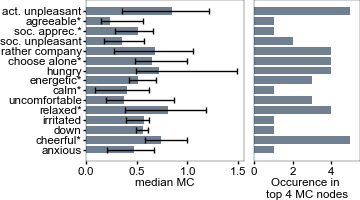

In [7]:
from ctrl.discrete_optimal_control2 import LQR
from ctrl import utils
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors

data = utils.load_data()    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
mc = np.zeros((len(data), len(features)))

statistic = 'median'

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['C']
    mc[j] = LQR.modal_ctrb(A)

top4mc = np.r_[np.argsort(mc, axis=1)[:,-1:-5:-1].flatten(), np.arange(len(features))].copy()
_, top4mc_counts = np.unique(top4mc, return_counts=True)
top4mc_counts -= 1

fig, axes = plt.subplots(1,2, figsize=(3.6,2), sharey=True, gridspec_kw={'width_ratios':(1.5,1)})
ax = axes[0]
if statistic=='median':
    interval = np.vstack((np.percentile(mc, 25, axis=0), np.percentile(mc, 75, axis=0)))
    bar_container = ax.barh(range(len(features)), np.median(mc, axis=0), color=colors.features,
            xerr=np.abs(np.median(mc, axis=0, keepdims=True)-interval), error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('median MC')
    # ax.set_xticks([0,15,30])
elif statistic=='mean':
    interval = stats.sem(mc, axis=0)
    bar_container = ax.barh(range(len(features)), np.mean(mc, axis=0), color=colors.features,
            xerr=interval, error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('mean MC')
ax.set_yticks(np.arange(len(features)), labels=features)
ax = axes[1]
ax.barh(range(len(features)), top4mc_counts)
ax.set_xlabel('Occurence in \ntop 4 MC nodes')
ax.set_xticks([0,2,4])
ax.set_xlim([0, 5.5])
ax.tick_params(left=False)
plt.savefig('figures/figure2E.png')

Network figure

d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_29820\1677837564.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


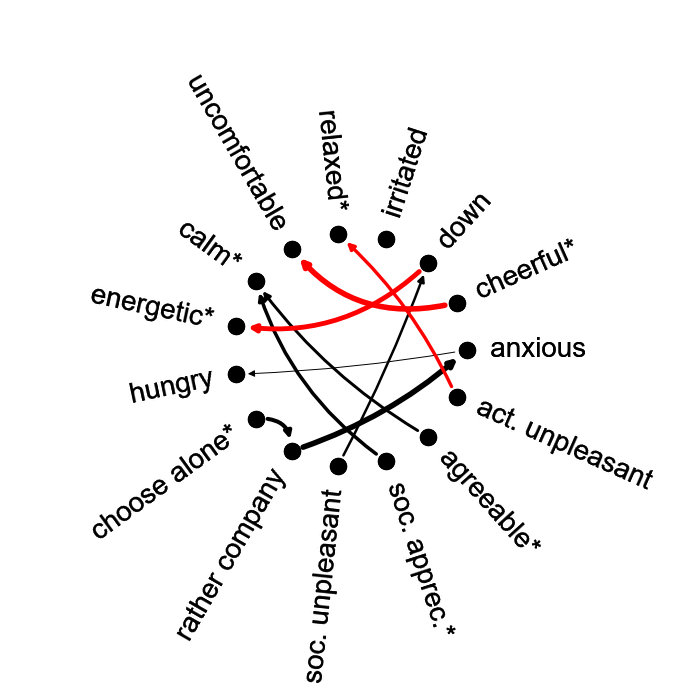

In [9]:
from scipy import stats
import matplotlib.pyplot as plt
from ctrl import utils
import numpy as np
from custom_rcparams_paper import colors

data = utils.load_data()    
features = data[0]['Xlabs']
A_matrices = np.zeros((len(data), len(features), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    A_matrices[j] = A
sig_adj = stats.ttest_1samp(A_matrices, 0, axis=0).pvalue

fig, ax = plt.subplots(figsize=(7,7))
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
A_mean = A_matrices.mean(axis=0)
for i in range(A_mean.shape[0]):
    A_mean[i,i] = 0
A_plus = np.where((sig_adj < 0.05) & (A_mean > 0), 
                  A_mean, 0)
A_minus = np.where((sig_adj < 0.05) & (A_mean < 0), 
                  A_mean, 0) * (-1)
utils.plot_circular_graph(A_plus, directed=True, labels=features, 
                          max_edge_width=4, max_edge_rad=-0.6,
                          node_kwargs={'node_size': 150, 'node_color': 'black'},
                          label_kwargs={'font_family': 'sans-serif', 'font_size': 20},
                          ax=ax)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
utils.plot_circular_graph(A_minus, directed=True, labels=features,
                          max_edge_width=4, max_edge_rad=-0.6, 
                          node_kwargs={'node_size': 150, 'node_color': 'black'}, 
                          edge_kwargs={'edge_color': 'r'},
                          label_kwargs={'font_family': 'sans-serif', 'font_size': 20},
                          ax=ax)
fig.tight_layout()
plt.savefig('figures/figure2F_adjacency.png')
plt.show()